# Deep Learning Inverse Kinematic

In diesem Notebook sollen Sie einen Einblick in das Thema Deep Learning mit Keras bekommen. Mit Hilfe von tiefen neuronalen Netzen werden Sie die Rückwärtstransformation für den YouBot von KUKA lösen. Dabei werden Sie lernen wie ein solches Netz mit Keras erzeugt wird und wie man es trainiert.

Hilfreiche Links:

- Inverse Kinematic mittels RNNs für Multi-Gelenkwinkel Roboter: https://uni-tuebingen.de/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/kognitive-systeme/projects/inverse-kinematics-with-recurrent-neural-networks/
- Keras API: https://keras.io/

## Idee

Wir möchten die Rückwärtstransformation für einen bestimmten Roboter, den YouBot, durchführen. Das bedeutet dass wir für einen von uns bestimmten Punkt im Raum die Gelenkwinkel bestimmen müssen die der Roboter einstellen muss, damit er diesen erreicht. Daraus ergeben sich auch Eingabe und Ausgabe des Netzes das wir erstellen, das Netz muss den TCP als Eingangsschicht erhalten und am Ende die Gelenkwinkelstellungen ausgeben.

## Vorbereitung der Daten

Einer der wichtigsten Aspekte beim supervised learning sind die Daten. Sie werden sehen, dass wir diese in unserem Fall ganz einfach erzeugen können. Da uns die Vorwärtstransformation bekannt ist können wir über diese für beliebig viele Gelenkwinkelstellungen den TCP errechnen lassen.

#### DH-Parametertabelle youBot

$\begin{array}{rr} \hline
\mathbf{Gelenk} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

Für die Vorwärtstransformation werden die DH-Parameter des YouBots benötigt die wir im folgenden Codebeispiel als numpy Arrays anlegen.

In [1]:
import numpy as np

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])

Wir programmieren nun eine Python-Funktion <b>dhIthFrame</b> zur Erstellung eines einzelnen DH-Frames. Als Parameter werden $\theta$, $d$, $a$ und $\alpha$ des entsprechenden Gelenkes angenommen.

In [2]:
def dhIthFrame(theta, d, a, alpha):
    
    rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
                            [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
                            [0, 0, 0, 1] ])
    
    trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
    trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
    rot_alpha = np.matrix([ [1, 0, 0, 0], 
                            [0, np.cos(alpha), -np.sin(alpha), 0], 
                            [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
    dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
    return dh_ith_frame;

Dieses DH-Frame ist unsere Blaupause für die Forwärtstransformation am youBot. Wir definieren eine Python-Funktion <b>buildDhTcpFrame</b>, in welcher wir die Argumente eines solchen DH-Frames durch die DH-Parameterfür die Gelenkwinkel $a_{1}$ bis $a_{5}$ einsetzen und die resultierenden Frames zu einem Ergebnis-Frame akkumulieren.

In [3]:
def buildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame

Mit dieser Funktion haben wir nun die Möglichkeit TCP und Ausrichtung für übergebene Gelenkwinkelstellungen auszurechnen. Für die Erzeugung unseres Datensatzes brauchen wir nur noch die Anzahl an Gelenkwinkelstellungen.
Dazu beachten wir die Gelenkwinkelgrezen jedes Gelenks am YouBot.

$\begin{array}{rr} \hline
\mathbf{Gelenk} &{Grenzen°} &{Grenzen°} \\ \hline
\mathbf{A1} &-169°        &169°  \\ \hline
\mathbf{A2} &-65°         &90°  \\ \hline
\mathbf{A3} &-150°        &146°   \\ \hline
\mathbf{A4} &-102.5°      &102.5°   \\ \hline
\mathbf{A5} &-167.5°      &167.5° \\ \hline
\end{array}$

Es gibt viele denkbare Möglichkeiten diese Gelenkwinkel zu generieren, diese sollen nicht Teil dieses Notebooks sein. Um das Notebook nicht zu überfluten wurden einige Funktionen in das Skript utils abgelegt. Ein naiver Ansatz wäre beispielsweise das völlig zufällige generieren von Gelenkwinkeln. Ein kurzes Code-Snippet, wie sie es in der Klasse zu finden ist als Beispiel:
```python
for joint_range in joint_limits:
    joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
    degree_joint_pos.append(joint_val)
degree_joint_pos = np.asarray(degree_joint_pos)
radians = np.radians(degree_joint_pos)     
```

Die einzelnen Gelenkwinkelgrenzen werden in einer Liste abgespeichert und es wird ein zufälliger Wert innerhalb dieser Grenze gezogen und in eine weitere Liste gespeichert. Die Werte in Grad werden zum Schluss in Bogenmaß umgerechnet.

In [4]:
import utils as u

datahandler = u.DataHandler()

Using TensorFlow backend.


Zum Test lassen erzeugen wir 100 Gelenkwinkelpositionen und die dazugehörigen TCP Frames.

In [5]:
import time
import numpy as np

start = time.time()

joint_pos, tcp = datahandler.generate_data(100)
end = time.time()
print("Berechnungszeit: %.2f Sekunden" %(end - start))

Berechnungszeit: 0.13 Sekunden


In [59]:
print("TCP Shape:", tcp.shape)
print("Joint Shape:", joint_pos.shape)

TCP Shape: (100, 12)
Joint Shape: (100, 5)


Nun können wir uns noch einige der TCP Frames anzeigen lassen und überprüfen ob sie richtig erzeugt wurden.

<IPython.core.display.Javascript object>


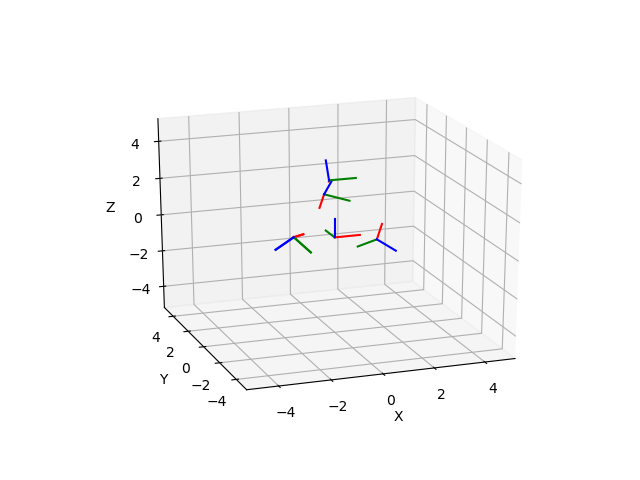

In [60]:
from mpl_toolkits import mplot3d
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import *
%matplotlib notebook

ax = plot_basis(R=np.eye(3), ax_s=5)
f = 5
samples = np.random.randint(0, len(tcp), 5)
for i in samples:
    point = np.asarray([tcp[i][3] *f, tcp[i][7] *f, tcp[i][11] *f])
    rot = np.asarray([[tcp[i][0], tcp[i][1], tcp[i][2]],
                      [tcp[i][4], tcp[i][5], tcp[i][6]],
                      [tcp[i][8], tcp[i][9], tcp[i][10]]])
    plot_basis(ax, R=rot, p=point)

plt.show()


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization

model = Sequential()
    
# layer = Dense(units=100, 
#           input_dim=12,
#           kernel_initializer='random_normal',
#           use_bias=True,
#           bias_initializer='random_normal',
#           activation='tanh')
layer = Dense(units=500, 
          input_dim=12,
          kernel_initializer='random_normal',
          use_bias=False)

model.add(layer)
model.add(BatchNormalization())
model.add(Activation('tanh'))

dropout = Dropout(0.5)
model.add(dropout)

hidden_layers = 2

for i in range(hidden_layers):
#     layer = Dense(units=100, 
#                   kernel_initializer='random_normal',
#                   use_bias=True,
#                   bias_initializer='random_normal',
#                   activation='tanh')
    layer = Dense(units=500, 
                  kernel_initializer='random_normal',
                  use_bias=False)
    model.add(layer)
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    if i is not (hidden_layers - 1):
        dropout = Dropout(0.5)
        model.add(dropout)
    
# layer = Dense(units=5, 
#               kernel_initializer='random_normal',
#               use_bias=True,
#               bias_initializer='random_normal',
#               activation='tanh')
layer = Dense(units=5, 
              kernel_initializer='random_normal',
              use_bias=False,
              activation='tanh')
model.add(layer)

In [9]:
import keras.backend as K
import tensorflow as tf

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])

def kdhIthFrame(theta, d, a, alpha):
    
    cosalpha = K.cast(K.cos(alpha), 'float32')
    sinalpha = K.cast(K.sin(alpha), 'float32')
    costheta = K.cast(K.cos(theta), 'float32')
    sintheta = K.cast(K.sin(theta), 'float32')
    zero = tf.zeros_like(theta)
    one = tf.ones_like(theta)
    d = tf.constant(d, dtype='float32')
    a = tf.constant(a, dtype='float32')
    
    rot_theta = [ [costheta, -sintheta, zero, zero], 
                  [sintheta, costheta, zero, zero], 
                  [zero, zero, one, zero],
                  [zero, zero, zero, one] ]
    
    trans_d = [ [one, zero, zero, zero], [zero, one, zero, zero], [zero, zero, one, d], [zero, zero, zero, one] ]
    trans_a = [ [one, zero, zero, a], [zero, one, zero, zero], [zero, zero, one, zero], [zero, zero, zero, one] ]
    
    rot_alpha = [ [one, zero, zero, zero], 
                  [zero, cosalpha, -sinalpha, zero], 
                  [zero, sinalpha, cosalpha, zero], 
                  [zero, zero, zero, one] ]
    
#     frame = [ [costheta, (-sintheta * cosalpha), (sintheta * sinalpha), (a * costheta)], 
#               [sintheta, (costheta * cosalpha), (-costheta * sinalpha), (a * sintheta)], 
#               [tf.zeros_like(theta), sinalpha, cosalpha, d], 
#               [tf.zeros_like(theta), tf.zeros_like(theta), tf.zeros_like(theta), tf.ones_like(theta)] ]
    
#     frame = tf.matmul(tf.matmul(tf.matmul(rot_theta, trans_d), trans_a), rot_alpha)
    print(K.shape(rot_alpha))
    print(K.shape(rot_theta))
    frame = tf.matmul(rot_theta, trans_d)
    
    return frame;


def kbuildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = kdhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame

In [10]:
import keras.utils as kutil

def custom_loss(y_gt, y_pred):

    tcp_out = kbuildDhTcpFrame(y_pred)
    print(tcp_out)
    print(K.shape(tcp_out))
    tcp_out = K.flatten(tcp_out)
    tcp_out = tcp_out[0:, :12]
    tcp_out = np.squeeze(tcp_out)
          
    xyz_gt = y_gt[3::4]
    xyz_pred = tcp_out[3::4]
    angles_gt = np.asarray([y_gt[0:3], y_gt[4:7], y_gt[8:11]]).flatten()
    angles_pred = np.asarray([tcp_out[0:3], tcp_out[4:7], tcp_out[8:11]]).flatten()

    mse = 0
    for i in range(3):
        mse += np.mean((angles_gt[i] - angles_pred[i]) **2)
    mse /= 3
    dist = np.linalg.norm(xyz_gt - xyz_pred)
    
    err = 0.4 * mse + 0.6 * dist

    return err

In [57]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
# For a mean squared error regression problem
rms = RMSprop(learning_rate=0.01, rho=0.9)
adam=Adam(lr=1.0e-3)

model.compile(optimizer=adam,loss='mse')

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               6000      
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250000    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)              

In [58]:
for i in range(2):
    print("Durchlauf: ",i)
    jpos, tpos = datahandler.generate_step(10000)
    model.fit(tpos, jpos, epochs=1000, batch_size=32, validation_split=0.1)

Durchlauf:  0
positions calculated
tcp calculated
duplicates erased
Train on 9000 samples, validate on 1000 samples
Epoch 1/1000
9000/9000 [==============================] - 4s 428us/step - loss: 0.2692 - val_loss: 0.5933
Epoch 2/1000
9000/9000 [==============================] - 3s 331us/step - loss: 0.1665 - val_loss: 0.6072
Epoch 3/1000
9000/9000 [==============================] - 3s 331us/step - loss: 0.1528 - val_loss: 0.6332
Epoch 4/1000
9000/9000 [==============================] - 3s 328us/step - loss: 0.1447 - val_loss: 0.6644
Epoch 5/1000
9000/9000 [==============================] - 3s 333us/step - loss: 0.1396 - val_loss: 0.6627
Epoch 6/1000
9000/9000 [==============================] - 3s 330us/step - loss: 0.1359 - val_loss: 0.6935
Epoch 7/1000
9000/9000 [==============================] - 3s 330us/step - loss: 0.1330 - val_loss: 0.7098
Epoch 8/1000
9000/9000 [==============================] - 3s 331us/step - loss: 0.1315 - val_loss: 0.6899
Epoch 9/1000
9000/9000 [============

KeyboardInterrupt: 

In [14]:
# model.fit_generator(generator = Generator().make(20), 
#                     validation_data  = Generator().make(10),
#                     steps_per_epoch  = 1000, 
#                     epochs           = 200,
#                     validation_steps = 100,
#                     workers = 6,
#                     use_multiprocessing = True)

In [15]:
# model.save('lo2ng.h5')

In [16]:
# model.load_weights('long.h5')

In [17]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') # True/False

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [61]:
%matplotlib notebook
pred_pos, pred_tcp = datahandler.generate_step(100)
out = model.predict(pred_tcp)
datahandler.denormalize(pred_pos)
# datahandler.denormalize(out)

# for i in range(10):
#     print(pred_pos[i])
#     print(out[i])

positions calculated
tcp calculated
duplicates erased


In [83]:
def custom_error(y_gt, y_pred):

    tcp_out = u.buildDhTcpFrame(y_pred)
    tcp_out = np.asarray(tcp_out.flatten())
    tcp_out = tcp_out[0:, :12]
    tcp_out = np.squeeze(tcp_out)
          
    xyz_gt = y_gt[3::4]
    xyz_pred = tcp_out[3::4]
    angles_gt = np.asarray([y_gt[0:3], y_gt[4:7], y_gt[8:11]]).flatten()
    angles_pred = np.asarray([tcp_out[0:3], tcp_out[4:7], tcp_out[8:11]]).flatten()

    mse = 0
    for i in range(3):
        mse += np.mean((angles_gt[i] - angles_pred[i]) **2)
    mse /= 3
    mse = np.mean((angles_gt - angles_pred) ** 2))
    dist = np.linalg.norm(xyz_gt - xyz_pred)
    
    err = 0.4 * mse + 0.6 * dist

    return err

In [84]:
# print(custom_loss(pred_tcp[0], pred_pos[0]))
# print(tcper(pred_pos[0]))
# print(pred_tcp[0])
print(custom_error(pred_tcp[0], out[0]))

0.04496921513591013


In [52]:
err = 0
lowest = 99999
n = 0
ranges = len(out)
for i in range(ranges):
    mse = custom_error(pred_tcp[i], out[i])
    err += mse
    if mse < lowest:
        lowest = mse
        n = i
err /= ranges
print(err)
print(n)

0.5357869294651735


<IPython.core.display.Javascript object>


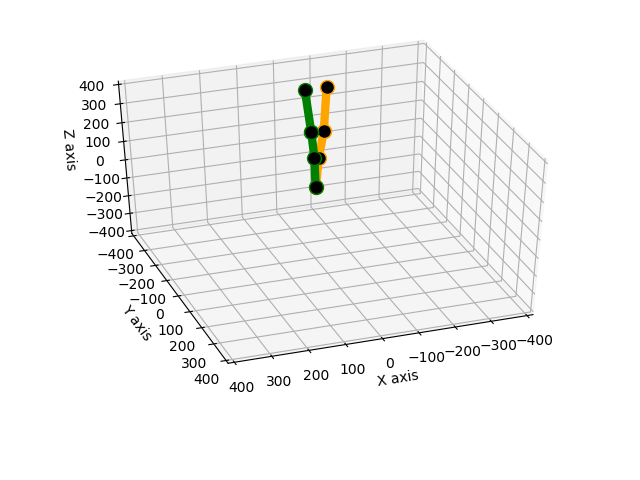

0.0353016969873704


In [64]:
%matplotlib notebook
drawer = u.Drawer()

o = 0
drawer.draw_robot(pred_pos[o], out[o])
print(custom_error(pred_tcp[o], out[o]))